# RNN for Time Series Prediction

This is a time series prediction task. You are given a dataset which reports on the weather and the level of pollution each hour for five years, and asked to train Recurrent Neural Networks (RNNs) to predict the hourly pollution level.

In [1]:
import numpy as np 
import pandas as pd 
import math
from datetime import datetime
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns 
from collections import Counter
%matplotlib inline

a) Load the data from the file. Perform necessary pre-processing (e.g., missing value replacement, uninformative attribute removal, etc.) and visualise the values of various attributes over the five-year period.

d:\program files (x86)\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


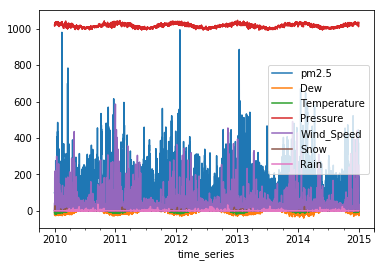

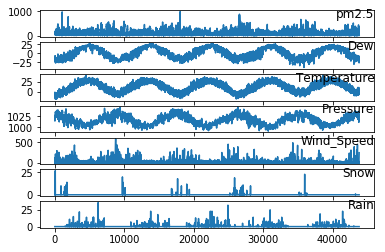

In [2]:
# write your code here

# load the data from the file
pollution = pd.read_csv('pollution.csv') 
# replace missing value with mean of that attribute
pollution = pollution.fillna(pollution.mean()) 
# replace 'cv' with the most frequent wind direction
pollution.Wind_Direction[pollution.Wind_Direction=='cv'] = pollution['Wind_Direction'].mode()[0]
# pollution
# inseret new attribute of time series 
time_series = []
for i in range(len(pollution)):
    t = datetime(pollution['year'][i],pollution['month'][i],pollution['day'][i],pollution['hour'][i])
    time_series.append(t)
time_series = pd.Series(time_series)
pollution.insert(0,'time_series',time_series)
# modify the index into time series
pollution.index = pollution['time_series'].tolist()
pollution.index.name = 'time_series'
# remove uninformative attribute: No, year, month, day, hour and time_series
pollution = pollution.drop(columns=['No','year','month','day','hour','time_series']) 

# visualise the values of various attributes over the five-year period
pollution.plot()
plt.show()
# or visualise seperately
index = [0, 1, 2, 3, 5, 6, 7]
i = 1
plt.figure()
for j in index:
    plt.subplot(len(index), 1, i)
    plt.plot(pollution.values[:, j])
    plt.title(pollution.columns[j], y=0.5, loc='right')
    i += 1
plt.show()

b) Frame the task as the supervised learning problem as predicting the pollution at the current hour given the pollution measurement and weather conditions at the previous hour. Using the first 4 years' data as the training set and the remaining 1 year's data as the test set. Prepare the training/test sets accordingly.

In [3]:
from sklearn import preprocessing

# write your code here

# integer encode wind direction
pollution[['Wind_Direction']] = preprocessing.LabelEncoder().fit_transform(pollution[['Wind_Direction']])
# normalize the dataset using minmax scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_pollution = scaler.fit_transform(pollution)
scaled_pollution = pd.DataFrame(scaled_pollution)

# frame the dataset as a supervised learning problem
def series_to_supervised(data, n_in, n_out):
    n_vars = data.values.shape[1]
    cols = []
    col_names = []
    # input sequence (t-1, ..., t-n)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        col_names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
            col_names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            col_names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    framed = pd.concat(cols, axis=1)
    framed.columns = col_names
    # drop rows with NaN values
    framed.dropna(inplace=True)
    return framed
            
framed_data = series_to_supervised(scaled_pollution,1,1)
framed_data.drop(framed_data.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# framed_data

# split the training/test sets
n_hours = 4 * 365 * 24
train = framed_data[:n_hours]
test = framed_data[n_hours:]
# split into input and outputs
X_train = train.values[:, :-1]
Y_train = train.values[:, -1]
X_test = test.values[:, :-1]
Y_test = test.values[:, -1]


d:\program files (x86)\python\python36\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\program files (x86)\python\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


c) Train a Recurrent Neural Network (RNN) on the training set. You can split the training set further by using 10% of the data as the validation set and the remaining for training.

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout

# write your code here
# split data as validation set and training set
split = int(len(X_train) * 0.1)
X_valid = X_train[:split, :]
Y_valid = Y_train[:split]
X_train = X_train[split:, :]
Y_train = Y_train[split:]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

# design RNN
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
# fit RNN
history = model.fit(X_train, Y_train, epochs=50, batch_size=144, validation_data=(X_valid, Y_valid), shuffle=False)

Using TensorFlow backend.


Train on 31536 samples, validate on 3504 samples
Epoch 1/50
31536/31536 [==============================] - 6s 183us/step - loss: 0.0543 - val_loss: 0.0392
Epoch 2/50
31536/31536 [==============================] - 2s 79us/step - loss: 0.0302 - val_loss: 0.0413
Epoch 3/50
31536/31536 [==============================] - 2s 75us/step - loss: 0.0264 - val_loss: 0.0463
Epoch 4/50
31536/31536 [==============================] - 2s 71us/step - loss: 0.0285 - val_loss: 0.0522
Epoch 5/50
31536/31536 [==============================] - 1s 43us/step - loss: 0.0307 - val_loss: 0.0449
Epoch 6/50
31536/31536 [==============================] - 2s 54us/step - loss: 0.0279 - val_loss: 0.0387
Epoch 7/50
31536/31536 [==============================] - 1s 38us/step - loss: 0.0251 - val_loss: 0.0364
Epoch 8/50
31536/31536 [==============================] - 1s 37us/step - loss: 0.0234 - val_loss: 0.0332
Epoch 9/50
31536/31536 [==============================] - 1s 44us/step - loss: 0.0221 - val_loss: 0.0324
Epoch

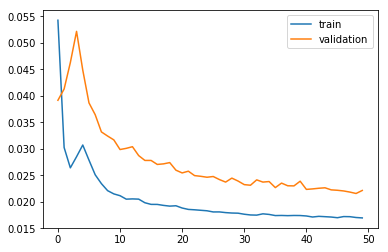

In [5]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

#### Finding:
The loss of validation set is larger than the loss of training set at around 0.022 and 0.017 respectively.

d) Output the prediction results such as Root Mean Squared Errors (RMSE) on the test set. Remember that after the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with other models. Plot the predicted values vs. the actual values.

RMSE on test set: 38.611


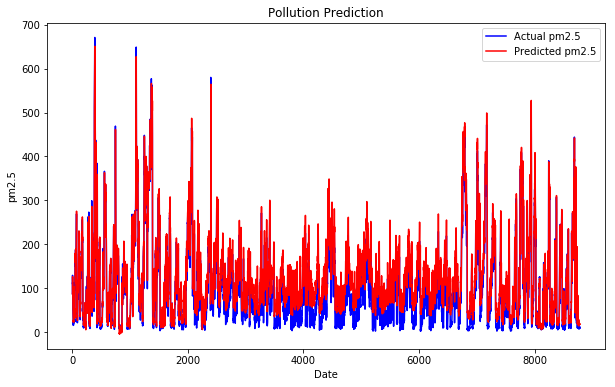

In [6]:
from sklearn.metrics import mean_squared_error

# write your code here

# make a prediction
Y_predict = model.predict(X_test)
re_X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_pred = np.concatenate((Y_predict, re_X_test[:, 1:]), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0]
# invert scaling for actual
Y_test = Y_test.reshape((len(Y_test), 1))
inv_test = np.concatenate((Y_test, re_X_test[:, 1:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
inv_test = inv_test[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_test, inv_pred))
print('RMSE on test set: %.3f' % rmse)

# plot the predicted values and the actual values
plt.figure(figsize=(10,6))  
plt.plot(inv_test, color='blue', label='Actual pm2.5')  
plt.plot(inv_pred , color='red', label='Predicted pm2.5')  
plt.title('Pollution Prediction')  
plt.xlabel('Date')  
plt.ylabel('pm2.5')  
plt.legend()  
plt.show()  

#### Finding:
The test RMSE of this modoel is: 38.611.  
And there is a certain deviation between the predicted value and the actual value.

e) Explore different network architectures (e.g., stacked LSTM layers) and various ways in tuning the model parameters to see if you can improve the model performance on the test set. 

In [7]:
# write your code here

# design RNN
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50))  
model2.add(Dropout(0.2))  
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit RNN
history = model2.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_valid, Y_valid), shuffle=False)
# make a prediction
Y_predict = model2.predict(X_test)
# invert scaling for forecast
inv_pred = np.concatenate((Y_predict, re_X_test[:, 1:]), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_test, inv_pred))
print('RMSE on test set: %.3f' % rmse)

Train on 31536 samples, validate on 3504 samples
Epoch 1/50
31536/31536 [==============================] - 14s 453us/step - loss: 0.0413 - val_loss: 0.0371
Epoch 2/50
31536/31536 [==============================] - 7s 231us/step - loss: 0.0201 - val_loss: 0.0194TA: 0s - lo
Epoch 3/50
31536/31536 [==============================] - 7s 209us/step - loss: 0.0174 - val_loss: 0.0155ETA: 2s - lo - ETA: 1s - loss:  - ETA: 1s - loss: 0.01 - ETA: 1s - loss: -
Epoch 4/50
31536/31536 [==============================] - 7s 220us/step - loss: 0.0165 - val_loss: 0.0157
Epoch 5/50
31536/31536 [==============================] - 8s 250us/step - loss: 0.0162 - val_loss: 0.0164
Epoch 6/50
31536/31536 [==============================] - 6s 196us/step - loss: 0.0159 - val_loss: 0.0162
Epoch 7/50
31536/31536 [==============================] - 7s 223us/step - loss: 0.0156 - val_loss: 0.0150
Epoch 8/50
31536/31536 [==============================] - 6s 193us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 9/50
31536/

#### Finding:
After trying adding the layers, tuning the number of epochs, tuning the batch size, I got a lower test RMSE: 24.388 and I also found:  
1. the number of layer has little influence to the result. But it seems that the increase in neurons results in increase in the RMSE.  
2. the bigger the number of epochs, the worse performance. But it took long time to run the code.  
3. batch_size has a great influence on performance and running time. I tried 18, 36, 72 and 144, 18 and 36 perform good, but 72 can balance the performance and the efficiency.  


f) Explore alterative prediction setup by predicting the pollution for the next hour based on the weather conditions and pollution over the last 3 days.

In [8]:
# write your code here

# specify the number of lag hours
n_hours = 3 * 24
# frame as supervised learning
reframed = series_to_supervised(scaled_pollution, n_hours, 1)
# split train and test set
n_train_hours = 4 * 365 * 24
train = reframed[:n_train_hours]
test = reframed[n_train_hours:]
# split into input and outputs
split_train = n_hours * 8
X_train = train.values[:, :split_train]
Y_train = train.values[:, -8]
X_test = test.values[:, :split_train]
Y_test = test.values[:, -8]
# split data as validation set and training set
split_valid = int(len(X_train) * 0.1)
X_valid = X_train[:split_valid, :]
Y_valid = Y_train[:split_valid]
X_train = X_train[split_valid:, :]
Y_train = Y_train[split_valid:]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))


Train on 31536 samples, validate on 3504 samples
Epoch 1/50
31536/31536 [==============================] - 17s 530us/step - loss: 0.0532 - val_loss: 0.0376
Epoch 2/50
31536/31536 [==============================] - 10s 331us/step - loss: 0.0392 - val_loss: 0.0328
Epoch 3/50
31536/31536 [==============================] - 6s 178us/step - loss: 0.0341 - val_loss: 0.0322
Epoch 4/50
31536/31536 [==============================] - 5s 156us/step - loss: 0.0323 - val_loss: 0.0318
Epoch 5/50
31536/31536 [==============================] - 5s 158us/step - loss: 0.0282 - val_loss: 0.0278
Epoch 6/50
31536/31536 [==============================] - 6s 193us/step - loss: 0.0293 - val_loss: 0.0292
Epoch 7/50
31536/31536 [==============================] - 6s 176us/step - loss: 0.0265 - val_loss: 0.0340
Epoch 8/50
31536/31536 [==============================] - 6s 187us/step - loss: 0.0254 - val_loss: 0.0283
Epoch 9/50
31536/31536 [==============================] - 6s 176us/step - loss: 0.0250 - val_loss: 0.

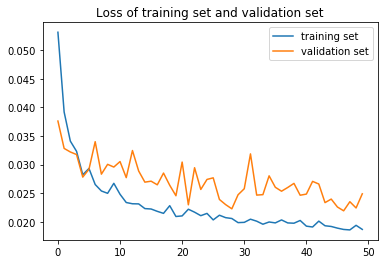

RMSE on test set: 41.316


In [10]:
# design RNN
model3 = Sequential()
model3.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(Dropout(0.2))
model3.add(LSTM(units=50))  
model3.add(Dropout(0.2))  
model3.add(Dense(1))
model3.compile(loss='mae', optimizer='adam')
# fit RNN
history = model3.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_valid, Y_valid), shuffle=False)
# plot history
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.title('Loss of training set and validation set')
plt.legend()
plt.show()

# make a prediction
Y_predict = model3.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], split_train))
# invert scaling for forecast
inv_pred = np.concatenate((Y_predict, X_test[:, -7:]), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0]
# invert scaling for forecast
Y_test = Y_test.reshape((len(Y_test), 1))
inv_test = np.concatenate((Y_test, X_test[:, -7:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
inv_test = inv_test[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_test, inv_pred))
print('RMSE on test set: %.3f' % rmse)

#### Finding:
The results of predicting based on the weather conditions and pollution over the last 3 days:  
1. The RMSE on test set is 41.316.(change every run)  
2. The loss of training set and validation set are around 0.020 and 0.025 respectively.